In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random

import numpy as np
import numpy.core.defchararray as np_string
import pandas as pd

import glob

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
work_dir = os.getcwd() 
train_dir = work_dir + '/train/'
test_dir = work_dir + '/test/'
model_path = work_dir + '/model/'

In [3]:
list_paths = glob.glob(train_dir + '*')
list_names = [i.replace(train_dir,'') for i in list_paths]
print(list_names)
name2ind = dict(zip(list_names, range(len(list_names))))
ind2name = dict(zip(range(len(list_names)),list_names))

['Sugar beet', 'Common Chickweed', 'Cleavers', 'Shepherds Purse', 'Charlock', 'Common wheat', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Scentless Mayweed', 'Fat Hen', 'Maize', 'Black-grass']


In [4]:
for i in list_names:
    print(i + ': ' + str(len(os.listdir(train_dir + i))) + ' pictures')

Sugar beet: 385 pictures
Common Chickweed: 611 pictures
Cleavers: 287 pictures
Shepherds Purse: 231 pictures
Charlock: 390 pictures
Common wheat: 221 pictures
Small-flowered Cranesbill: 496 pictures
Loose Silky-bent: 654 pictures
Scentless Mayweed: 516 pictures
Fat Hen: 475 pictures
Maize: 221 pictures
Black-grass: 263 pictures


In [38]:
train_set = list()
train_label_list = list()
test_set = list()
test_label_list = list()

for i in list_names:
    glob_per_dir = glob.glob(train_dir + i + '/*')
    n_plants = len(glob_per_dir)
    n_train = int(np.round(0.8*n_plants))
    train_path_per_glob = random.sample(glob_per_dir, n_train)
    test_path_per_glob = list(set(glob_per_dir) - set(train_path_per_glob))
    train_set.extend(train_path_per_glob)
    test_set.extend(test_path_per_glob)
    train_label_list.extend([i]*n_train)
    test_label_list.extend([i]*(len(glob_per_dir) - n_train))
    
train_label = [name2ind[i] for i in train_label_list]
test_label = [name2ind[i] for i in test_label_list]

In [41]:
test_label_for_cm = test_label.copy()

In [6]:
from skimage.transform import resize as imresize
import imageio

def img_reshape(img):
    img = imresize(img, (51, 51, 3))
    return img

def img_get(path):
    img = imageio.imread(path)
    img = img_reshape(img)
    return img
train_img = [img_get(i) for i in train_set]
test_img = [img_get(i) for i in test_set]

/home/bsong/venv/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/bsong/venv/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
print(len(train_img), len(train_label))

3801 3801


In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
import keras.backend as K

K.clear_session()

# Dense layers set
def dense_set(inp_layer, n, activation, drop_rate=0.):
    dp = Dropout(drop_rate)(inp_layer)
    dns = Dense(n)(dp)
    bn = BatchNormalization(axis=-1)(dns)
    act = Activation(activation=activation)(bn)
    return act

# Conv. layers set
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1,1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1/10)(bn)
    return act

# simple model 
def get_model():
    inp_img = Input(shape=(51, 51, 3))

    # 51
    conv1 = conv_layer(inp_img, 64, zp_flag=False)
    conv2 = conv_layer(conv1, 64, zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 128, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv4)
    # 9
    conv7 = conv_layer(mp2, 256, zp_flag=False)
    conv8 = conv_layer(conv7, 256, zp_flag=False)
    conv9 = conv_layer(conv8, 256, zp_flag=False)
    mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # 1
    # dense layers
    flt = Flatten()(mp3)
    ds1 = dense_set(flt, 128, activation='tanh')
    out = dense_set(ds1, 12, activation='softmax')

    model = Model(inputs=inp_img, outputs=out)
    
    # The first 50 epochs are used by Adam opt.
    # Then 30 epochs are used by SGD opt.
    
    #mypotim = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    mypotim = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                   optimizer=mypotim,
                   metrics=['accuracy'])
    model.summary()
    return model

#model = get_model()

In [42]:
from keras.utils import to_categorical
train_img = np.array(train_img)
test_img = np.array(test_img)
train_label = to_categorical(np.array(train_label))
test_label = to_categorical(np.array(test_label))


In [64]:
class_weights = dict(zip(range(len(list_names)), [1]*len(list_names)))
class_weights[7] = 1.5
class_weights[11] = 3
class_weights[2] = 1.3
class_weights[4] = .9

In [67]:
BATCH_SIZE = 32
EPOCHS = 15
RANDOM_STATE = 11

def get_callbacks(filepath, patience=5):
    lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=1e-5, patience=patience, verbose=1)
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, msave]

def train_model(xtr,ytr,xte,yte, model_path, start_ = 'new'):
    
    callbacks = get_callbacks(filepath = model_path + 'model_weight_SGD.hdf5', patience = 3)
    model_ = get_model()
    if start_ == 'update':
        model_.load_weights(filepath = model_path + 'model_weight_SGD.hdf5')
    gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.3,
            height_shift_range=0.3,
            horizontal_flip=True,
            vertical_flip=True
            )#zoom_range=0.3,
            
    
#     model_.fit_generator(gen.flow(xtr,ytr, batch_size = BATCH_SIZE),
#                        steps_per_epoch=10*len(xtr)/BATCH_SIZE,
#                        epochs=EPOCHS,
#                        verbose=1,
#                        shuffle=True,
#                        validation_data=(xte, yte),
#                        callbacks=callbacks)
    
    model_.fit_generator(gen.flow(xtr, ytr, batch_size = BATCH_SIZE),
                   steps_per_epoch=10*len(xtr)/BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=1,
                   shuffle=True,
                   validation_data=gen.flow(xte, yte, batch_size = BATCH_SIZE),
                   validation_steps=len(xte) / BATCH_SIZE,
                   callbacks=callbacks,
                   class_weight=class_weights)

In [68]:
train_model(train_img, train_label, test_img, test_label, model_path, start_='update')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 51, 51, 3)         0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_208 (Bat (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_162 (LeakyReLU)  (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_209 (Bat (None, 47, 47, 64)        256       
_________________________________________________________________
leaky_re_lu_163 (LeakyReLU)  (None, 47, 47, 64)        0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 51, 51, 3)         0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_217 (Bat (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_169 (LeakyReLU)  (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_218 (Bat (None, 47, 47, 64)        256       
_________________________________________________________________
leaky_re_lu_170 (LeakyReLU)  (None, 47, 47, 64)        0         
__________

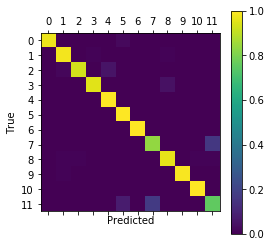

{0: 'Sugar beet', 1: 'Common Chickweed', 2: 'Cleavers', 3: 'Shepherds Purse', 4: 'Charlock', 5: 'Common wheat', 6: 'Small-flowered Cranesbill', 7: 'Loose Silky-bent', 8: 'Scentless Mayweed', 9: 'Fat Hen', 10: 'Maize', 11: 'Black-grass'}


In [69]:
model_ = get_model()
model_.load_weights(filepath = model_path + 'model_weight_SGD.hdf5')
prob = model_.predict(test_img, verbose=1)
pred = prob.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
best_confmat = confusion_matrix(np.array(test_label_for_cm), pred)
total_bins = best_confmat.shape[0]


import numpy as np
import matplotlib.pyplot as plt
sum_rows = np.sum(best_confmat,axis=1) # this line is summing up the total ground-truth values that were accounted for. 
nonzero_axis = [i for i in range(len(sum_rows)) if sum_rows[i] !=0] # in case some classes were never predicted (maybe very sparse), then this 
                                                                    # makes it not so ugly
scaled_confmat = best_confmat[nonzero_axis] / sum_rows[nonzero_axis,None] # if the distribution of classes were skewed, then the heatmap would 
                                                                          # be a bit awkward (bigger classes would get most of the color weight)

plt.matshow(scaled_confmat)
plt.colorbar()
tick_marks = np.arange(total_bins)
plt.xticks(tick_marks, range(total_bins))
plt.yticks(tick_marks,nonzero_axis)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(ind2name)


In [70]:
## test set

def test_model():
    test_imgs = glob.glob(test_dir + '/*')
    
    test_set = np.array([img_get(i) for i in test_imgs])
    test_names = [i.replace(test_dir,'') for i in test_imgs]
    
    model_ = get_model()
    model_.load_weights(filepath = model_path + 'model_weight_SGD.hdf5')
    prob = model_.predict(test_set, verbose=1)
    pred = prob.argmax(axis=-1)
    sub = pd.DataFrame({"file": test_names,
                         "species": [ind2name[p] for p in pred]})
    #sub.to_csv("sub.csv", index=False, header=True)
    return sub

output = test_model()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 51, 51, 3)         0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_226 (Bat (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_176 (LeakyReLU)  (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_227 (Bat (None, 47, 47, 64)        256       
_________________________________________________________________
leaky_re_lu_177 (LeakyReLU)  (None, 47, 47, 64)        0         
__________

In [71]:
output.to_csv('/home/bsong/Play/submissions/balanced_cnn_valacc9610.csv', index=False)